In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import struct

In [2]:
def write_to_output(data_array, file):
    """TODO."""
    file.write(str(data_array[0]))
    if len(data_array) > 1:
        for datum in data_array[1:]:
            file.write(" " + str(datum))
    file.write("\n")
        

def read_from_binary(type_string, file):
    """TODO."""
    return struct.unpack(type_string, file.read(struct.calcsize(type_string)))

class PositReader:
    """TODO."""
    def __init__(self, posit_file):
        """TODO."""
        self.input_file = posit_file
        self.output_file = posit_file + ".hr"
    
    def make_human_readable(self):
        """TODO."""
        with open(self.input_file, 'rb') as fin, open(self.output_file, 'w+') as fout:
            # Read header: n_steps, n_posit, timestep (int int double)
            header = read_from_binary("iid", fin)

            # Write header
            write_to_output(["n_steps", "n_posit", "delta"], fout)
            write_to_output(header, fout)
            
            # Read body
            write_to_output(["n_particles", "pos_x", "pos_y", "pos_z", "spos_x", "spos_y",
                             "spos_z", "u_x", "u_y", "u_z", "diameter", "length"], fout)
            n_samples = header[0]//header[1]
            for sample in range(n_samples):
                # read number of particles (int), 4 bytes
                num = read_from_binary("i", fin)[0]
                # Read num_particles * posits, each of which are 11 doubles (88 bytes)
                # These correspond to avg_pos (x,y,z), scaled_avg_pos (x,y,z), 
                # orientation (x,y,z), diameter, and length
                posits = read_from_binary("ddddddddddd"*num, fin)
                write_to_output([num] + list(posits), fout)

In [5]:
_ = PositReader('../filament_test_filament.posit').make_human_readable()

In [7]:
params = pd.read_csv("../filament_test_filament.posit.hr", delim_whitespace=True, nrows=1)
posits = pd.read_csv("../filament_test_filament.posit.hr", skiprows=3, delim_whitespace=True, header=None)

In [8]:
n_samples = posits.shape[0]
n_particles = posits.iloc[0, 0]
n_folds = 1
n_it = n_samples//n_folds
msd = np.zeros(n_it)
msd_err = np.zeros(n_it)
vcf = np.zeros(n_it)
vcf_err = np.zeros(n_it)
for it in range(n_it):
    dr = np.array([])
    du = np.array([])
    for fold in range(n_folds):
        # Mean square displacement
        dr = np.append(dr, np.array([np.sum((posits.iloc[fold*n_it+it, i:i+3] - posits.iloc[fold*n_it, i:i+3])**2) for i in range(1, 11*n_particles+1, 11)]))
        # Vector correlation function
        du = np.append(du, np.array([np.sum((posits.iloc[fold*n_it+it, i:i+3] - posits.iloc[fold*n_it, i:i+3])**2) for i in range(7, 11*n_particles+1, 11)]))

    msd[it] = np.mean(dr)
    msd_err[it] = np.std(dr)
    vcf[it] = np.mean(du)
    vcf_err[it] = np.std(du)

msd_err = msd_err/np.sqrt(n_particles*n_folds)
vcf_err = vcf_err/np.sqrt(n_particles*n_folds)

In [9]:
delta = params.delta[0]
n_steps = params.n_steps[0]
length = posits.iloc[0, 11]
diameter = posits.iloc[0, 10]
t = np.linspace(0, 0.5*params.delta[0]*(params.n_steps[0]-2)/n_folds, n_it)

In [10]:
Dcom = np.log(length/diameter)/length
Drot = 9 * np.log(length/diameter) / length**3
msd_theory = lambda t: 6*Dcom*t
vcf_theory = lambda t: 2*(1 - np.exp(-2*Drot*t))

NameError: name 'fig' is not defined

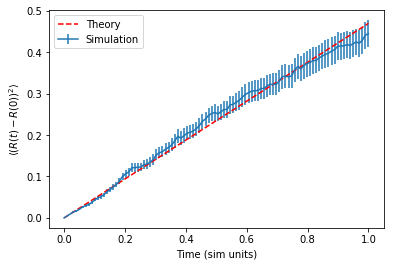

In [42]:
plt.figure()
plt.errorbar(t, msd, yerr=msd_err, label="Simulation")
plt.plot(t, msd_theory(t), 'r--', label="Theory")
plt.legend()
plt.xlabel("Time (sim units)")
plt.ylabel(r"$\langle (R(t) - R(0))^2 \rangle$")
fig.tight_layout()
plt.savefig("msd_l050_lp50k_n100.png", dpi=300)
plt.show()

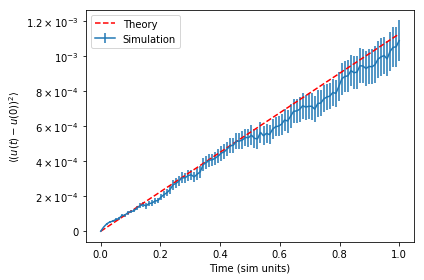

In [41]:
plt.figure()
plt.errorbar(t, vcf, yerr=vcf_err, label="Simulation")
plt.plot(t, vcf_theory(t), 'r--', label="Theory")
plt.legend()
plt.xlabel("Time (sim units)")
plt.ylabel(r"$\langle (u(t) - u(0))^2 \rangle$")
locs, labels = plt.yticks()
new_labels = [
    plt.Text(0,-0.0002,'−0.0002'),
    plt.Text(0,0,'0'),
    plt.Text(0,0.0002,r'$2\times10^{-4}$'),
    plt.Text(0,0.0004,r'$4\times10^{-4}$'),
    plt.Text(0,0.0006,r'$6\times10^{-4}$'),
    plt.Text(0,0.0008,r'$8\times10^{-4}$'),
    plt.Text(0,0.001,r'$10^{-3}$'),
    plt.Text(0,0.0012,r'$1.2\times10^{-3}$'),
    plt.Text(0,0.0014,r'$1.4\times10^{-3}$')
]
plt.yticks(locs[1:-1], new_labels[1:-1])
plt.tight_layout()
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig("vcf_l050_lp50k_n100.png", dpi=300)
plt.show()

In [352]:
1/(np.log(50)/50)

12.781110931766573

In [354]:
1/(50**2 * 12.78)

3.129890453834116e-05

In [22]:
locs

array([-0.0002,  0.    ,  0.0002,  0.0004,  0.0006,  0.0008,  0.001 ,
        0.0012,  0.0014])

In [24]:
for i in labels:
    print(i)

Text(0,-0.0002,'−0.0002')
Text(0,0,'0.0000')
Text(0,0.0002,'0.0002')
Text(0,0.0004,'0.0004')
Text(0,0.0006,'0.0006')
Text(0,0.0008,'0.0008')
Text(0,0.001,'0.0010')
Text(0,0.0012,'0.0012')
Text(0,0.0014,'0.0014')
